In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import sys

sys.path.append("../../")

In [336]:
from tokenizers import Tokenizer
import sys

import matplotlib.pyplot as plt
import numpy as np
import collections
import torch

from ChEmbed.data import chembldb, smiles_dataset, chembed_tokenize
from ChEmbed.training import trainer
from ChEmbed.modules import simple_rnn

from ChEmbed import plots, utilities

In [20]:
chembl_raw = chembldb.ChemblDB()
chembl_smiles = chembl_raw._load_or_download()["canonical_smiles"]

In [21]:
tokenizer = chembed_tokenize.load_chembed_tokenizer(filepath = "../data/tokenizers/tokenizer-chembldb-16-06-2025.json")

In [344]:
chembl_dataset = smiles_dataset.SMILESDataset(
    smiles_list = chembl_smiles,
    tokenizer = tokenizer
)

chembl_mini = chembl_dataset = smiles_dataset.SMILESDataset(
    smiles_list = chembl_smiles[:1048],
    tokenizer = tokenizer
)

In [345]:
model = simple_rnn.simpleRNN(
    # Mandatory
    num_hiddens = 64,
    vocab_size = len(tokenizer),
    # tuning
    learning_rate = 0.2,
    weight_decay = 0.01
)

In [346]:
chembl_dataset[0].type(torch.float32)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [347]:
model.forward(next(iter(chembl_dataset)))

tensor([[-0.0600, -0.0107, -0.0660,  ..., -0.0373, -0.0373, -0.0373],
        [ 0.1196,  0.0355,  0.1351,  ...,  0.1457,  0.1457,  0.1457],
        [-0.1480, -0.1109, -0.0839,  ..., -0.1240, -0.1240, -0.1240],
        ...,
        [ 0.0329, -0.0527,  0.0584,  ...,  0.0409,  0.0409,  0.0409],
        [-0.0874, -0.0529, -0.1211,  ..., -0.1089, -0.1089, -0.1089],
        [ 0.2451,  0.2186,  0.2012,  ...,  0.2490,  0.2490,  0.2490]],
       grad_fn=<TransposeBackward0>)

In [348]:
def predict(input, num_preds, model, dataset, device=None):
    state, outputs = None, [input[0]]

    # predict input + num_preds tokens
    for i in range(len(input) + num_preds - 1):
        X = torch.tensor(dataset.encode_smiles_to_one_hot(outputs[i]), device=device)
        
        rnn_outputs, state = model.rnn(X, state)

        if i < len(input) - 1:
            outputs.append(input[i + 1])
        else:
            Y = dataset.tokenizer.decode(model.linear(rnn_outputs).argmax())
            outputs.append(Y)

    return ''.join(outputs)
            

In [356]:
print(predict("CHCC", 15, model, chembl_dataset))

/var/folders/ql/140bddls19x4s8xyk9nrwyd00000gn/T/ipykernel_16882/1428639691.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(dataset.encode_smiles_to_one_hot(outputs[i]), device=device)


CHCC<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


In [350]:
model_trainer = trainer.Trainer(max_epochs=16, init_random=42)
model_trainer.fit(model, chembl_mini)

Training batch 1/17... (Epoch 1/16)
Training batch 2/17... (Epoch 1/16)
Training batch 3/17... (Epoch 1/16)
Training batch 4/17... (Epoch 1/16)
Training batch 5/17... (Epoch 1/16)
Training batch 6/17... (Epoch 1/16)
Training batch 7/17... (Epoch 1/16)
Training batch 8/17... (Epoch 1/16)
Training batch 9/17... (Epoch 1/16)
Training batch 10/17... (Epoch 1/16)
Training batch 11/17... (Epoch 1/16)
Training batch 12/17... (Epoch 1/16)
Training batch 13/17... (Epoch 1/16)
Training batch 14/17... (Epoch 1/16)
Training batch 15/17... (Epoch 1/16)
Training batch 16/17... (Epoch 1/16)
Training batch 17/17... (Epoch 1/16)
Training batch 1/17... (Epoch 2/16)
Training batch 2/17... (Epoch 2/16)
Training batch 3/17... (Epoch 2/16)
Training batch 4/17... (Epoch 2/16)
Training batch 5/17... (Epoch 2/16)
Training batch 6/17... (Epoch 2/16)
Training batch 7/17... (Epoch 2/16)
Training batch 8/17... (Epoch 2/16)
Training batch 9/17... (Epoch 2/16)
Training batch 10/17... (Epoch 2/16)
Training batch 11/1

In [358]:
print(predict("CCccCC", 15, model, chembl_dataset))

/var/folders/ql/140bddls19x4s8xyk9nrwyd00000gn/T/ipykernel_16882/1428639691.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(dataset.encode_smiles_to_one_hot(outputs[i]), device=device)


CCccCC<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


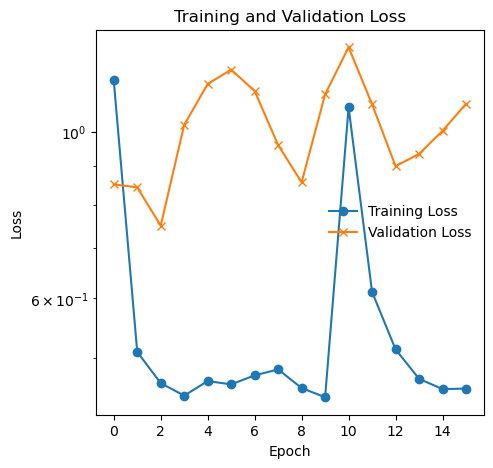

In [352]:
losses = utilities.extract_training_losses(model_trainer.metadata)
fig, ax = plots.plot_training_validation_loss(losses['avg_train_losses'], losses['avg_val_losses'])
ax.set_yscale('log')